# **Predicting Personality Traits based on LinkedIn Profiles:** A study that aims to assess the Big 5 personality traits of individuals based on publicly available LinkedIn signals using different models

# **1.** Exploratory Data Analysis

Required Packages

In [1]:
import pandas as pd
import numpy as np
import io
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier

Load the dataset from Fernandez at al. (2021)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.csv to Dataset.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['Dataset.csv']))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Columns: 438 entries, Participant to Neuroticism_scale
dtypes: float64(79), int64(358), object(1)
memory usage: 2.0+ MB


In [5]:
df.head()

,Participant,age2018,gender,IPIP_NEO_Item1,IPIP_NEO_Item2,IPIP_NEO_Item3,IPIP_NEO_Item4,IPIP_NEO_Item5,IPIP_NEO_Item6,IPIP_NEO_Item7,...,Opennes_1Indicator,Conscientiousness_Nb_Indicators,Conscientiousness_3Indicators,Conscientiousness_2Indicators,Conscientiousness_1Indicator,Openness_scale,Conscientiousness_scale,Extraversion_scale,Agreeableness_scale,Neuroticism_scale
0,1,23.0,1,5,4,4,2,5,1,2,...,0.0,2.0,0.0,1.0,1.0,3.98,3.53,4.12,3.28,3.00
1,2,23.0,1,4,5,5,5,5,4,2,...,NaN,NaN,NaN,NaN,NaN,4.22,4.62,4.32,4.18,2.33
2,3,23.0,1,4,2,4,4,5,4,2,...,0.0,2.0,0.0,1.0,1.0,3.05,3.78,3.20,3.62,3.23
3,4,30.0,1,4,5,4,5,5,1,2,...,0.0,0.0,0.0,0.0,0.0,3.68,4.78,3.75,4.15,1.90
4,5,23.0,1,4,4,4,3,4,2,2,...,1.0,1.0,0.0,0.0,1.0,4.08,3.13,3.80,3.22,2.93


We delete the columns we do not need, i.e. subscales and the number of subscales an individual fulfills.
We further drop a few single columns, such an undefined variable where we cannot find information about in the code book, the Partcipant ID as well as the background topic (which is a string and thus we cannot use it as a feature).

Further, we discard the 'Groups' variable which is supposed to represent a zero when the participant is in the lower terecentile and a one if the participant is in the upper tercentile.

In [6]:
cols1 = [*range(3, 338, 1)] #IPIP-300 items
cols2 = [*range(393, 433, 1)] #Nr of indicators (calculated by Fernandez et al.)
cols = cols1+cols2
df.drop(df.columns[cols], axis=1, inplace=True)
df.drop(['Openness_groups', 'Conscientiousness_groups', 'Extraversion_groups', 'Agreeableness_groups'], axis=1, inplace=True)
df.drop(['E_Medias_nonwork', 'Participant', 'Background_topic', 'A_Smile_Coder2', 'A_Smile_Coder1', 'E_Number_connections_Coder2'], axis=1, inplace=True)

The features are (despite age) variables that are publically available on LinkedIn, e.g., hnumber of spoken languages, professional background picture (yes/no), etc.
The 5 values to be predicted are 'Extraversion_scale', 'Conscientiousness_scale',
       'Openness_scale', 'Agreeableness_scale', 'Neuroticism_scale' and can have values from 1-5 where 5 represents a very high score. In this skript we will only try to predict Agreeableness.

We define the mean and median as well as the upper and lower tercentile.

In [7]:
agreeableness_mean_whole = df.Agreeableness_scale.mean()
agreeableness_median_whole = df.Agreeableness_scale.median()
agreeableness_upperterc_thr = df.Agreeableness_scale.quantile([2/3]).values[0]
agreeableness_lowerterc_thr = df.Agreeableness_scale.quantile([1/3]).values[0]
print(agreeableness_mean_whole, agreeableness_median_whole, df.Agreeableness_scale.quantile([1/3,2/3]))

3.5166227347611203 3.53 0.333333    3.37
0.666667    3.68
Name: Agreeableness_scale, dtype: float64


<Axes: >

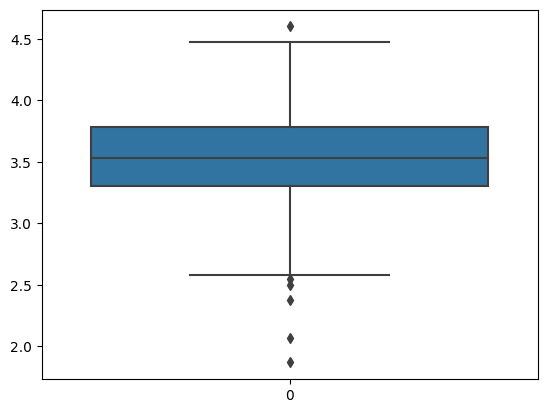

In [8]:
sns.boxplot(df['Agreeableness_scale'])

We now assess how many datapoints we have per level. We can see that no values =< 2 exist in the dataset. Most of the variables lie between 3 and 4.5. Hence, we barely have observations on the edges of the scale.

In [9]:
scale_bins_small = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
cuts = pd.cut(df['Agreeableness_scale'], bins=scale_bins_small)

counts = cuts.value_counts().sort_values()
print(counts)

(0.5, 1.0]      0
(1.0, 1.5]      0
(1.5, 2.0]      1
(4.5, 5.0]      1
(2.0, 2.5]      3
(2.5, 3.0]     45
(4.0, 4.5]     51
(3.0, 3.5]    242
(3.5, 4.0]    264
Name: Agreeableness_scale, dtype: int64


In [10]:
scale_bins = [0, 1, 2, 3, 4, 5]
cuts = pd.cut(df['Agreeableness_scale'], bins=scale_bins)

counts = cuts.value_counts().sort_values()
print(counts)

(0, 1]      0
(1, 2]      1
(2, 3]     48
(4, 5]     52
(3, 4]    506
Name: Agreeableness_scale, dtype: int64


We will implement a multi-classificationa pproach later on, thus, we will round the values to see in which category from 1 to 5 they will fall into.

In [11]:
scale_rounded = df['Agreeableness_scale'].round(0)
scale_rounded.value_counts()

4.0    325
3.0    277
2.0      4
5.0      1
Name: Agreeableness_scale, dtype: int64

In [12]:
binary_features = df[['gender',
                  'Background_photo',
                  'O_Background_art',
                  'E_Background_HumanInteractions',
                  'Profile_photograph',
                  'C_Professional_Attire',
                  'C_Summary',
                  'C_Updated_profile',
                  'Medias_work',
                  'C_Experience_described',
                  'Skill_section',
                  'A_Teamwork_listed',
                  'Teamwork_endorsed',
                  'Customer_service_listed',
                  'Customer_service_endorsed',
                  'E_Social_skills_listed',
                  'Social_skills_endorsed',
                  'E_Leadership_listed',
                  'Leadership_endorsed',
                  'E_Public_speaking_listed',
                  'Public_speaking_endorsed',
                  'C_Organization_listed',
                  'Organization_endorsed',
                  'O_Curiosity_listed',
                  'Curiosity_endorsed',
                  'C_Additional_certification',
                  'C_Academic_Award',
                  'C_Course_list',
                  'C_GPA',
                  'A_Volunteer_activity',
                  'C_Ambassador',
                  'O_Social_responsibility',
                  'E_Sport_Activity',
                  'C_Class_representative',
                  'O_Artistic_activity',
                  'A_Peer_tutoring',
                  'E_Leader_role',
                  'A_Recommendations_given',
                  'Recommendations_received_all',
                  'C_Recommendations_received_superior',
                  'C_Inattentiveness']]

non_binary_cols = df.columns.difference(binary_features.columns)
non_binary_features = df[non_binary_cols]

We construct the correlation matrix to assess whether multicollinearity is present. The problem of multicollinearity will be discussed in the main paper.

In [13]:
features = pd.concat([non_binary_features, binary_features], axis=1)
correlation_matrix = features.corr()
correlation_matrix

,A_MeanSmile,Agreeableness_scale,Conscientiousness_scale,E_Number_connections_Coder1,E_Number_skills_Coder1,E_Number_skills_Coder2,Extraversion_scale,Neuroticism_scale,O_Influencers,O_Number_languages,...,O_Social_responsibility,E_Sport_Activity,C_Class_representative,O_Artistic_activity,A_Peer_tutoring,E_Leader_role,A_Recommendations_given,Recommendations_received_all,C_Recommendations_received_superior,C_Inattentiveness
A_MeanSmile,1.000000,0.214299,0.034423,0.121495,-0.018203,-0.018597,0.034816,0.102912,0.003573,0.008766,...,0.129994,-0.013690,0.089891,0.006774,0.063285,0.101923,0.039931,0.063692,0.045301,-0.061162
Agreeableness_scale,0.214299,1.000000,0.339690,0.013478,-0.036843,-0.037445,0.047826,-0.100800,0.035031,0.030824,...,0.103523,-0.071949,0.060521,0.078277,0.059843,0.044019,0.068504,0.019549,-0.005197,-0.020590
Conscientiousness_scale,0.034423,0.339690,1.000000,0.073051,0.080300,0.080903,0.104999,-0.333494,0.064481,0.045953,...,0.034583,-0.005194,0.093894,0.014905,0.121206,0.080687,0.060132,0.089392,0.091433,0.030595
E_Number_connections_Coder1,0.121495,0.013478,0.073051,1.000000,0.333448,0.333971,0.313523,-0.075650,0.196959,0.110387,...,0.029105,0.147894,0.148030,0.076623,0.066444,0.260357,0.152994,0.156046,0.146070,0.042379
E_Number_skills_Coder1,-0.018203,-0.036843,0.080300,0.333448,1.000000,0.999736,0.156059,-0.130229,0.263809,0.018479,...,-0.005796,0.157493,0.112258,0.060599,0.012109,0.115473,0.232131,0.206291,0.239192,0.037143
E_Number_skills_Coder2,-0.018597,-0.037445,0.080903,0.333971,0.999736,1.000000,0.157942,-0.130562,0.263284,0.017699,...,-0.005965,0.156486,0.113691,0.060393,0.011133,0.114957,0.233205,0.205920,0.238834,0.037535
Extraversion_scale,0.034816,0.047826,0.104999,0.313523,0.156059,0.157942,1.000000,-0.405148,0.086628,0.016555,...,-0.023635,0.165923,0.092237,0.036801,-0.017635,0.144947,0.092499,0.030169,0.066173,0.006930
Neuroticism_scale,0.102912,-0.100800,-0.333494,-0.075650,-0.130229,-0.130562,-0.405148,1.000000,0.015021,-0.069858,...,0.028815,-0.164126,-0.029808,-0.052592,-0.020709,-0.090830,-0.030376,-0.020469,-0.057147,0.007360
O_Influencers,0.003573,0.035031,0.064481,0.196959,0.263809,0.263284,0.086628,0.015021,1.000000,-0.002598,...,-0.062991,0.068747,0.121268,-0.002038,0.001963,0.096382,0.228159,0.156313,0.179215,0.073967
O_Number_languages,0.008766,0.030824,0.045953,0.110387,0.018479,0.017699,0.016555,-0.069858,-0.002598,1.000000,...,0.041300,0.080134,0.041374,0.108284,0.099217,0.106731,0.083327,0.005298,0.007713,0.048051


In [14]:
correlation_matrix.to_excel('correlation_matrix_df.xlsx')
files.download('correlation_matrix_df.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We set a correlation of .10 as a threshold:

In [15]:
threshold = .10
high_corr = correlation_matrix[abs(correlation_matrix) > threshold]
high_corr['Agreeableness_scale']

A_MeanSmile                            0.214299
Agreeableness_scale                    1.000000
Conscientiousness_scale                0.339690
E_Number_connections_Coder1                 NaN
E_Number_skills_Coder1                      NaN
E_Number_skills_Coder2                      NaN
Extraversion_scale                          NaN
Neuroticism_scale                     -0.100800
O_Influencers                               NaN
O_Number_languages                          NaN
Openness_scale                         0.201518
age2018                                     NaN
gender                                 0.281552
Background_photo                            NaN
O_Background_art                            NaN
E_Background_HumanInteractions              NaN
Profile_photograph                          NaN
C_Professional_Attire                       NaN
C_Summary                                   NaN
C_Updated_profile                           NaN
Medias_work                             

In [16]:
non_binary_features.columns.values

array(['A_MeanSmile', 'Agreeableness_scale', 'Conscientiousness_scale',
       'E_Number_connections_Coder1', 'E_Number_skills_Coder1',
       'E_Number_skills_Coder2', 'Extraversion_scale',
       'Neuroticism_scale', 'O_Influencers', 'O_Number_languages',
       'Openness_scale', 'age2018'], dtype=object)

In [17]:
binary_features.columns.values

array(['gender', 'Background_photo', 'O_Background_art',
       'E_Background_HumanInteractions', 'Profile_photograph',
       'C_Professional_Attire', 'C_Summary', 'C_Updated_profile',
       'Medias_work', 'C_Experience_described', 'Skill_section',
       'A_Teamwork_listed', 'Teamwork_endorsed',
       'Customer_service_listed', 'Customer_service_endorsed',
       'E_Social_skills_listed', 'Social_skills_endorsed',
       'E_Leadership_listed', 'Leadership_endorsed',
       'E_Public_speaking_listed', 'Public_speaking_endorsed',
       'C_Organization_listed', 'Organization_endorsed',
       'O_Curiosity_listed', 'Curiosity_endorsed',
       'C_Additional_certification', 'C_Academic_Award', 'C_Course_list',
       'C_GPA', 'A_Volunteer_activity', 'C_Ambassador',
       'O_Social_responsibility', 'E_Sport_Activity',
       'C_Class_representative', 'O_Artistic_activity', 'A_Peer_tutoring',
       'E_Leader_role', 'A_Recommendations_given',
       'Recommendations_received_all',
     

In [20]:
df_descr = df[['Agreeableness_scale',
               'A_MeanSmile',
               'gender',
               'A_Volunteer_activity',
               'A_Teamwork_listed',
               'O_Social_responsibility']]

df_descr[['Agreeableness_scale']] = df_descr[['Agreeableness_scale']].round(0)
df_descr.describe()

<ipython-input-20-851e705d1457>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descr[['Agreeableness_scale']] = df_descr[['Agreeableness_scale']].round(0)


,Agreeableness_scale,A_MeanSmile,gender,A_Volunteer_activity,A_Teamwork_listed,O_Social_responsibility
count,607.000000,562.000000,607.000000,606.000000,563.000000,606.000000
mean,3.532125,4.577402,0.606260,0.346535,0.726465,0.074257
std,0.515636,1.843175,0.488981,0.476259,0.446169,0.262406
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,1.000000,0.000000,1.000000,0.000000
75%,4.000000,6.500000,1.000000,1.000000,1.000000,0.000000
max,5.000000,7.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
df_descr_2 = df_descr[df_descr['Agreeableness_scale'] == 2]
df_descr_2.describe()

,Agreeableness_scale,A_MeanSmile,gender,A_Volunteer_activity,A_Teamwork_listed,O_Social_responsibility
count,4.0,3.000000,4.0,4.0,4.00000,4.0
mean,2.0,3.333333,0.0,0.0,0.50000,0.0
std,0.0,1.892969,0.0,0.0,0.57735,0.0
min,2.0,2.000000,0.0,0.0,0.00000,0.0
25%,2.0,2.250000,0.0,0.0,0.00000,0.0
50%,2.0,2.500000,0.0,0.0,0.50000,0.0
75%,2.0,4.000000,0.0,0.0,1.00000,0.0
max,2.0,5.500000,0.0,0.0,1.00000,0.0


In [22]:
df_descr_3 = df_descr[df_descr['Agreeableness_scale'] == 3]
df_descr_3.describe()

,Agreeableness_scale,A_MeanSmile,gender,A_Volunteer_activity,A_Teamwork_listed,O_Social_responsibility
count,277.0,255.000000,277.000000,276.000000,256.000000,277.000000
mean,3.0,4.174510,0.480144,0.282609,0.675781,0.054152
std,0.0,1.887573,0.500510,0.451086,0.468999,0.226726
min,3.0,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.0,2.750000,0.000000,0.000000,0.000000,0.000000
50%,3.0,4.500000,0.000000,0.000000,1.000000,0.000000
75%,3.0,6.000000,1.000000,1.000000,1.000000,0.000000
max,3.0,7.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df_descr_4 = df_descr[df_descr['Agreeableness_scale'] == 4]
df_descr_4.describe()

,Agreeableness_scale,A_MeanSmile,gender,A_Volunteer_activity,A_Teamwork_listed,O_Social_responsibility
count,325.0,303.000000,325.000000,325.000000,302.000000,324.000000
mean,4.0,4.920792,0.720000,0.403077,0.774834,0.092593
std,0.0,1.732145,0.449691,0.491272,0.418385,0.290309
min,4.0,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.0,3.500000,0.000000,0.000000,1.000000,0.000000
50%,4.0,5.500000,1.000000,0.000000,1.000000,0.000000
75%,4.0,6.500000,1.000000,1.000000,1.000000,0.000000
max,4.0,7.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df_descr_5 = df_descr[df_descr['Agreeableness_scale'] == 5]
df_descr_5.describe()

,Agreeableness_scale,A_MeanSmile,gender,A_Volunteer_activity,A_Teamwork_listed,O_Social_responsibility
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,5.0,7.0,1.0,1.0,0.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,5.0,7.0,1.0,1.0,0.0,0.0
25%,5.0,7.0,1.0,1.0,0.0,0.0
50%,5.0,7.0,1.0,1.0,0.0,0.0
75%,5.0,7.0,1.0,1.0,0.0,0.0
max,5.0,7.0,1.0,1.0,0.0,0.0


## **1.1.** PCA

We perform PCA to extract the

In [18]:
df_pca = df.copy()
scales = df_pca[['Extraversion_scale',
             'Conscientiousness_scale',
             'Openness_scale',
             'Agreeableness_scale',
             'Neuroticism_scale']]

non_binary_data = (non_binary_features - non_binary_features.mean())/non_binary_features.std()
data = pd.concat([non_binary_data, binary_features], axis=1)

scales_cols = scales.columns

#df with z-transformed features
features_ztrans = data.drop(scales_cols, axis=1)

In [19]:
features_ztrans.fillna(999, inplace=True)

pca = PCA(n_components=20)
components = pca.fit_transform(features_ztrans)

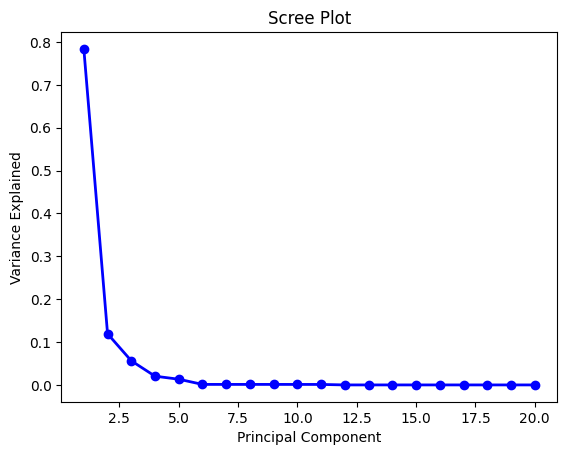

In [20]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [21]:
selected_components = components[:, :5] # 5 is chosen according to elbow plot

PCA_labels = {
    str(i): f'PC {i+1} ({var:.1f}%)'
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

In [22]:
fig = px.scatter_matrix(
    selected_components,
    labels = PCA_labels,
    dimensions = range(5), # 5 is chosen according to elbow plot
    color=scales.Agreeableness_scale)

fig.update_traces(diagonal_visible=False)
fig.show()

# **2.** Pre-processing

In [23]:
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

X = df[['A_MeanSmile', 'gender', 'A_Volunteer_activity', 'A_Teamwork_listed', 'O_Social_responsibility']] #'C_Experience_described', 'Teamwork_endorsed', 'C_Organization_listed'
Y = df[['Agreeableness_scale']]

scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y.iloc[:,0], test_size=.2, random_state=42)

y_test = y_test.round(0)
y_train = y_train.round(0)

<ipython-input-23-84f0d561c1ce>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We want to compare how well we did for each model we created. As we will do this same step for all models, we define a function we can use later on:

In [24]:
def confusion_matrix_plot(Y_TEST, Y_PRED, model_name=''):

  cm = confusion_matrix(Y_TEST, Y_PRED)
  sns.heatmap(cm, annot=True, cmap='Blues')

  xlabel_name = 'Predicted Labels: ' + model_name
  plt.xlabel(xlabel_name)
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')

  class_names = ['Class 3', 'Class 4']

  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
  plt.show()

# **Part 1:**

# **3.** Model comparison

In this section different models will be compared to a baseline which is basically the average value someone obtains on the Agreeableness Scale

## **3.1.** Baseline

In [25]:
y_pred_base = y_test.replace(to_replace=[1, 2, 3, 4, 5], value=4)

In [26]:
accuracy = accuracy_score(y_test, y_pred_base)
print('Model accuracy:', accuracy)

Model accuracy: 0.5819672131147541


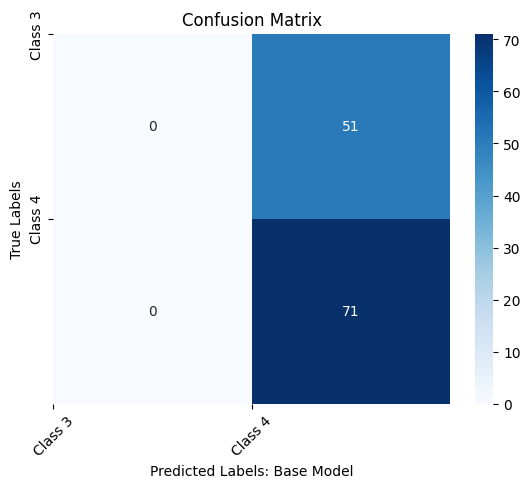

In [27]:
confusion_matrix_plot(y_test, y_pred_base, 'Base Model')

## **3.2.** Multinomial Logistic Regression


In [29]:
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_lr.fit(x_train, y_train)

y_probabilities = model_lr.predict_proba(x_test)
y_pred_lr = model_lr.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_lr)
print('Model accuracy:', accuracy)

Model accuracy: 0.6229508196721312


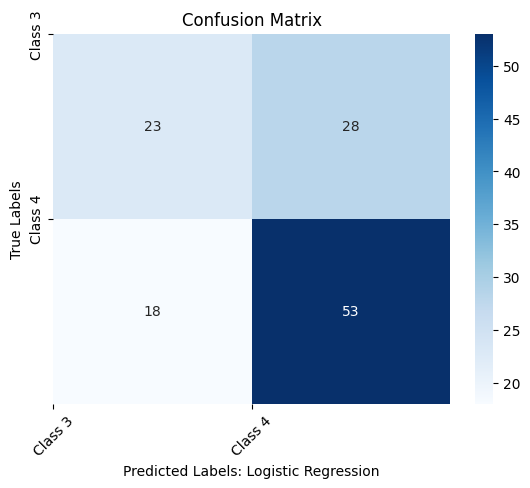

In [30]:
confusion_matrix_plot(y_test, y_pred_lr, 'Logistic Regression')

## **3.3.** Multinomial Logistic Regression (PCA)

In [31]:
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

X_pca = pd.DataFrame(selected_components).iloc[:, :] #from PCA section above
Y = df[['Agreeableness_scale']]

agreeableness_upperterc_thr = df.Agreeableness_scale.quantile([2/3]).values[0]

scaler = MinMaxScaler()
X_pca[X_pca.columns] = scaler.fit_transform(X_pca)

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, Y.iloc[:,0], test_size=.2, random_state=42)

y_test_pca = y_test_pca.round(0)
y_train_pca = y_train_pca.round(0)

In [32]:
model_pca = LogisticRegression(multi_class='multinomial', solver='lbfgs')

model_pca.fit(x_train_pca, y_train_pca)

y_probabilities_pca = model_pca.predict_proba(x_test_pca)
y_pred_pca = model_pca.predict(x_test_pca)

accuracy = accuracy_score(y_test_pca, y_pred_pca)
print('Model accuracy:', accuracy)

Model accuracy: 0.5573770491803278


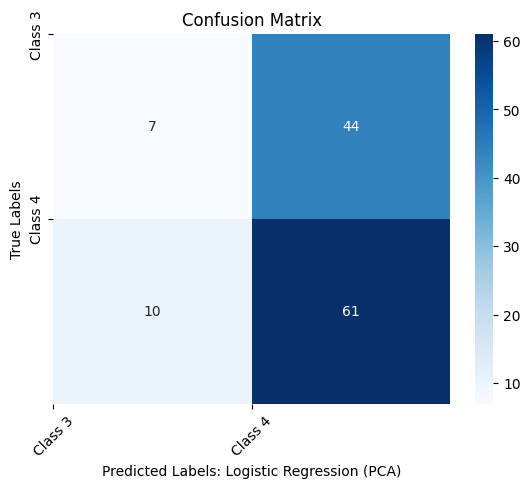

In [ ]:
confusion_matrix_plot(y_test, y_pred_pca, 'Logistic Regression (PCA)')

## **3.4.** eXtreme Gradient Boosting


In [ ]:
encoder = LabelEncoder()
y_train_encoded = y_train.astype(int) - y_train.min().astype(int)
y_test_encoded = y_test.astype(int) - y_train.min().astype(int)

ordered_categories = pd.CategoricalDtype(categories=[0, 1, 2, 3], ordered=True)

y_train_encoded = pd.Series(y_train_encoded).astype(ordered_categories).cat.codes
y_test_encoded = pd.Series(y_test_encoded).astype(ordered_categories).cat.codes

param_grid = {
    'max_depth': [10, 12],
    'learning_rate': [.01, .005, .001],
    'n_estimators': [350, 400, 500],
}

model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = 2)
grid_search.fit(x_train, y_train_encoded)

best_model_xgb = grid_search.best_estimator_

y_pred_xgb = best_model_xgb.predict(x_test)

print('Chosen model:', best_model_xgb)

accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print('Model accuracy:', accuracy)

y_pred_xgb = y_pred_xgb.astype(int)
y_pred_xgb += y_train.min().astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



Chosen model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=350, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Model accuracy: 0.5655737704918032


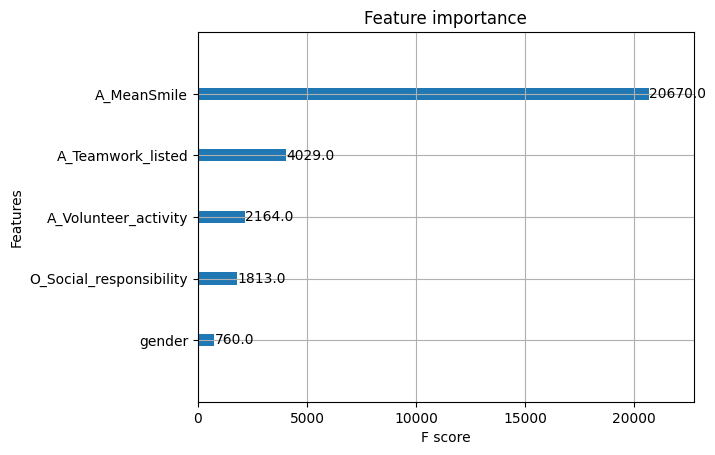

In [ ]:
xgb.plot_importance(best_model_xgb)
plt.show()

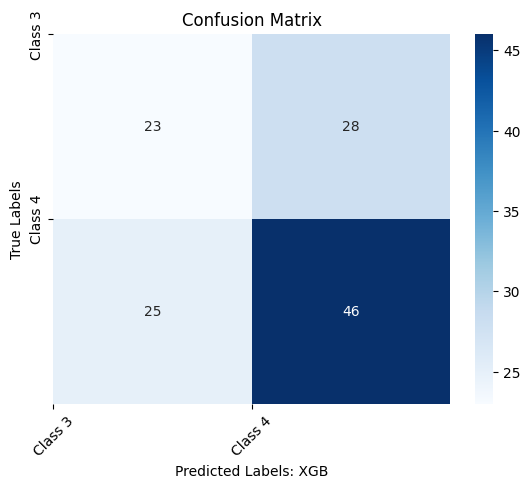

In [ ]:
confusion_matrix_plot(y_test, y_pred_xgb, 'XGB')

## **3.5.** Histogram Gradient Boosting

In [ ]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

param_grid = {
    'max_depth': [10, 11, 12],
    'learning_rate': [.00085, .001, .0015],
    'max_iter': [300, 400, 450],
}

model = HistGradientBoostingClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search.fit(x_train, y_train_encoded)

best_model_hgb = grid_search.best_estimator_

y_pred_hgb = best_model_hgb.predict(x_test)

print('Chosen model:', best_model_hgb)

accuracy = accuracy_score(y_test_encoded, y_pred_hgb)
print('Model accuracy:', accuracy)

y_pred_hgb = encoder.inverse_transform(y_pred_hgb)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



Chosen model: HistGradientBoostingClassifier(learning_rate=0.00085, max_depth=10,
                               max_iter=450)
Model accuracy: 0.5573770491803278


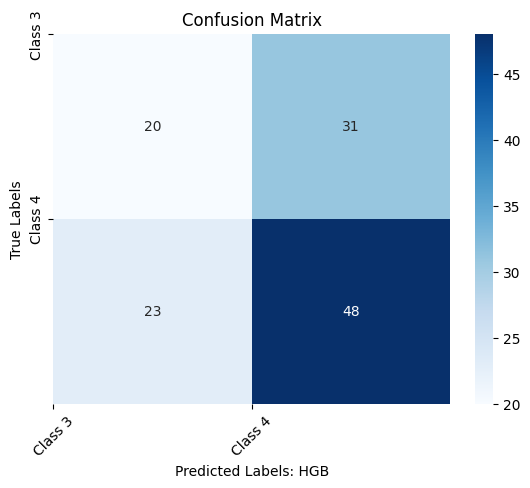

In [ ]:
confusion_matrix_plot(y_test, y_pred_hgb, 'HGB')

## **3.6.** Neural Network

In [ ]:
scaler = StandardScaler()
x_train_nn = scaler.fit_transform(x_train)
x_test_nn = scaler.transform(x_test)

label_binarizer = LabelBinarizer()
y_train_encoded = label_binarizer.fit_transform(y_train)

def create_model(activation='relu', hidden_layer_sizes=(100, 100), alpha=.0001):
    model_nn = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_layer_sizes[0], input_shape=(x_train_nn.shape[1],), activation=activation),
        tf.keras.layers.Dense(hidden_layer_sizes[1], activation=activation),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_nn

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=100, verbose=1)

param_grid = {
    'activation': ['sigmoid'],  #['relu', 'sigmoid']
    'hidden_layer_sizes': [(100, 100, 100)],  #[(100, 100), (50, 50)]
    'alpha': [.002, .0015, .001, .0009 ]  #[.0001, .001, .01]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_result = grid.fit(x_train_nn, y_train_encoded)

print('Best hyperparameters: ', grid_result.best_params_)

best_model_nn = grid_result.best_estimator_
y_pred_nn = best_model_nn.predict(x_test_nn)
y_pred_nn = y_pred_nn.astype(int)
y_pred_nn += 2

accuracy = accuracy_score(y_test, y_pred_nn)
print('Model accuracy:', accuracy)

<ipython-input-39-01b951b8e7c9>:17: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Epoch 1/100
13/13 [==============================] - 1s 4ms/step - loss: 1.1204 - accuracy: 0.5232
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7745 - accuracy: 0.4948
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7427 - accuracy: 0.5309
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7262 - accuracy: 0.6108
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7278 - accuracy: 0.5515
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7224 - accuracy: 0.5387
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7149 - accuracy: 0.6366
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.6031
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7056 - accuracy: 0.6263
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.6469
Epoch 11/

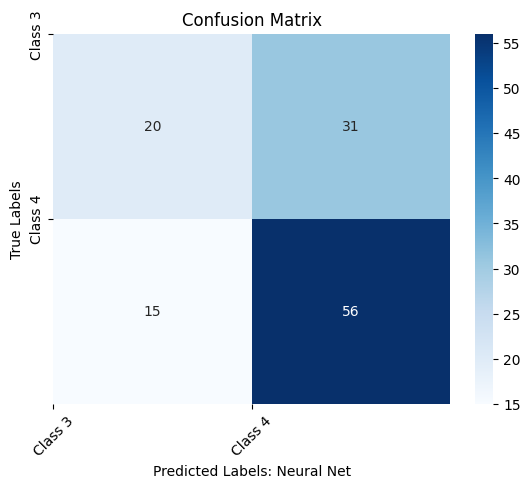

In [ ]:
confusion_matrix_plot(y_test, y_pred_nn, 'Neural Net')

# **Part 2:**

# **4.** Cross Validation

We read in the dataset we generated manually by sending out the questionnaire. We received 34 responses in total. In this part, we will see how well the pre-trained models perform on our dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CrossValidationSet_120623.csv to CrossValidationSet_120623.csv


In [ ]:
cv = pd.read_csv(io.BytesIO(uploaded['CrossValidationSet_120623.csv']), delimiter = ';', decimal=',')

In [ ]:
cv.head()

,Participant,age2018,gender,IPIP_NEO_Item1,IPIP_NEO_Item2,IPIP_NEO_Item3,IPIP_NEO_Item4,IPIP_NEO_Item5,IPIP_NEO_Item6,IPIP_NEO_Item7,...,Agreeableness_scale,Neuroticism_scale,Age,(Future) applicable industry,(Future) specified profession,(Future) specified profession (sublevel),(Future) position,(Planned) start of first full-time position,Social media usage in general,LinkedIn usage
0,1,26,1,2,4,2,5,5,3,2,...,4.533333,1.983333,26,consulting,strategy,HR,full-time,2023,low,low
1,2,26,1,3,4,4,4,4,1,2,...,4.183333,1.900000,26,consulting,strategy,nd,full-time,2023,medium,medium
2,3,29,0,4,5,4,3,5,2,3,...,3.616667,2.300000,29,legal,legal consulting,nd,full-time,2025,medium,medium
3,4,25,0,2,4,3,4,5,1,4,...,3.100000,1.716667,25,consulting,strategy,nd,full-time,2023,low,medium
4,5,26,1,5,4,3,4,4,3,5,...,3.800000,3.766667,26,consulting,strategy,nd,full-time,2023,high,medium


We apply the same **preprocessing** as to the dataset above

In [ ]:
cols1 = [*range(3, 338, 1)] #IPIP-300 items
cols2 = [*range(393, 433, 1)] #Nr of indicators (calculated by Fernandez et al.)
cols3 = [*range(len(cv.columns)-8, len(cv.columns), 1)]
cols = cols1+cols2+cols3
cv.drop(cv.columns[cols], axis=1, inplace=True)
cv.drop(['Extraversion_groups', 'Conscientiousness_groups', 'Openness_groups', 'Agreeableness_groups'], axis=1, inplace=True)
cv.drop(['E_Medias_nonwork', 'Participant', 'Background_topic', 'A_Smile_Coder2', 'A_Smile_Coder1', 'E_Number_connections_Coder2'], axis=1, inplace=True)

We check whether the characteristics distinguish from the dataset by Fernandez et al. (2021)

In [ ]:
agreeableness_mean_whole_cv = cv.Agreeableness_scale.mean()
agreeableness_median_whole_cv = cv.Agreeableness_scale.median()
agreeableness_upperterc_thr_cv = cv.Agreeableness_scale.quantile([2/3]).values[0]
agreeableness_lowerterc_thr_cv = cv.Agreeableness_scale.quantile([1/3]).values[0]
print(agreeableness_mean_whole, agreeableness_median_whole_cv, cv.Agreeableness_scale.quantile([1/3,2/3]))

3.5166227347611203 3.6416666665 0.333333    3.35
0.666667    3.80
Name: Agreeableness_scale, dtype: float64


<Axes: >

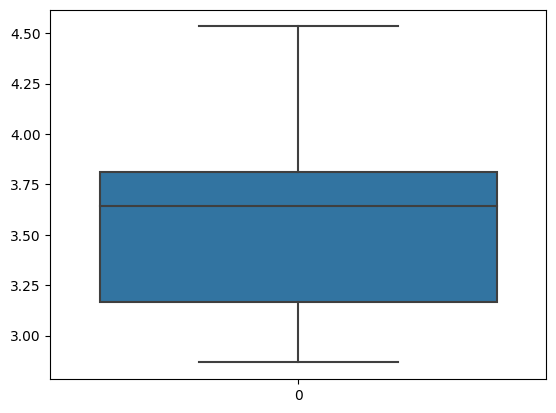

In [ ]:
sns.boxplot(cv['Agreeableness_scale'])

In [ ]:
scale_bins_small_cv = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
cuts = pd.cut(cv['Agreeableness_scale'], bins=scale_bins_small_cv)

counts = cuts.value_counts().sort_values()
print(counts)

(0.5, 1.0]     0
(1.0, 1.5]     0
(1.5, 2.0]     0
(2.0, 2.5]     0
(4.5, 5.0]     1
(4.0, 4.5]     2
(2.5, 3.0]     3
(3.0, 3.5]    11
(3.5, 4.0]    17
Name: Agreeableness_scale, dtype: int64


In [ ]:
scale_bins_CV = [0, 1, 2, 3, 4, 5]
cuts = pd.cut(cv['Agreeableness_scale'], bins=scale_bins_CV)

counts = cuts.value_counts().sort_values()
print(counts)

(0, 1]     0
(1, 2]     0
(2, 3]     3
(4, 5]     3
(3, 4]    28
Name: Agreeableness_scale, dtype: int64


In [ ]:
rounded = cv['Agreeableness_scale'].round(0)
rounded.value_counts()

4.0    19
3.0    14
5.0     1
Name: Agreeableness_scale, dtype: int64

In [ ]:
binary_features_cv = cv[['gender',
                  'Background_photo',
                  'O_Background_art',
                  'E_Background_HumanInteractions',
                  'Profile_photograph',
                  'C_Professional_Attire',
                  'C_Summary',
                  'C_Updated_profile',
                  'Medias_work',
                  'C_Experience_described',
                  'Skill_section',
                  'A_Teamwork_listed',
                  'Teamwork_endorsed',
                  'Customer_service_listed',
                  'Customer_service_endorsed',
                  'E_Social_skills_listed',
                  'Social_skills_endorsed',
                  'E_Leadership_listed',
                  'Leadership_endorsed',
                  'E_Public_speaking_listed',
                  'Public_speaking_endorsed',
                  'C_Organization_listed',
                  'Organization_endorsed',
                  'O_Curiosity_listed',
                  'Curiosity_endorsed',
                  'C_Additional_certification',
                  'C_Academic_Award',
                  'C_Course_list',
                  'C_GPA',
                  'A_Volunteer_activity',
                  'C_Ambassador',
                  'O_Social_responsibility',
                  'E_Sport_Activity',
                  'C_Class_representative',
                  'O_Artistic_activity',
                  'A_Peer_tutoring',
                  'E_Leader_role',
                  'A_Recommendations_given',
                  'Recommendations_received_all',
                  'C_Recommendations_received_superior',
                  'C_Inattentiveness']]

non_binary_cols_cv = cv.columns.difference(binary_features_cv.columns)
non_binary_features_cv = cv[non_binary_cols_cv]

In [ ]:
features_cv = pd.concat([non_binary_features_cv, binary_features_cv], axis=1)
correlation_matrix_cv = features_cv.corr()
correlation_matrix_cv

,A_MeanSmile,Agreeableness_scale,Conscientiousness_scale,E_Number_connections_Coder1,E_Number_skills_Coder1,E_Number_skills_Coder2,Extraversion_scale,Neuroticism_scale,O_Influencers,O_Number_languages,...,O_Social_responsibility,E_Sport_Activity,C_Class_representative,O_Artistic_activity,A_Peer_tutoring,E_Leader_role,A_Recommendations_given,Recommendations_received_all,C_Recommendations_received_superior,C_Inattentiveness
A_MeanSmile,1.000000,0.227346,-0.049269,-0.257169,-0.278265,-0.278265,0.012112,0.125714,-0.246447,0.216202,...,-0.439739,-0.133079,-0.066442,-0.137928,0.139863,-0.196091,0.075821,-0.076223,-0.076223,-0.353833
Agreeableness_scale,0.227346,1.000000,0.157058,-0.311403,-0.255636,-0.255636,0.100956,-0.032134,-0.056961,0.138685,...,-0.237544,-0.038961,-0.014971,0.107958,-0.279661,-0.057479,0.202240,0.081889,0.081889,-0.211636
Conscientiousness_scale,-0.049269,0.157058,1.000000,0.136184,-0.043678,-0.043678,0.233588,-0.165817,-0.260969,0.356574,...,0.237973,-0.199859,0.313987,0.119660,0.036411,0.172519,-0.378686,-0.265730,-0.265730,-0.196096
E_Number_connections_Coder1,-0.257169,-0.311403,0.136184,1.000000,0.281307,0.281307,0.124649,0.107568,0.357646,0.133917,...,0.371400,0.065703,0.264733,0.240653,-0.049648,0.086829,-0.017656,-0.033860,-0.033860,0.527089
E_Number_skills_Coder1,-0.278265,-0.255636,-0.043678,0.281307,1.000000,1.000000,-0.186700,-0.052756,0.678609,0.161453,...,0.143985,0.045973,0.181472,-0.004343,-0.039911,-0.032182,0.048382,0.057179,0.057179,0.476768
E_Number_skills_Coder2,-0.278265,-0.255636,-0.043678,0.281307,1.000000,1.000000,-0.186700,-0.052756,0.678609,0.161453,...,0.143985,0.045973,0.181472,-0.004343,-0.039911,-0.032182,0.048382,0.057179,0.057179,0.476768
Extraversion_scale,0.012112,0.100956,0.233588,0.124649,-0.186700,-0.186700,1.000000,-0.186880,-0.073305,0.170187,...,0.184210,0.134622,0.379442,-0.007875,-0.020747,0.167868,0.010589,0.162933,0.162933,-0.021556
Neuroticism_scale,0.125714,-0.032134,-0.165817,0.107568,-0.052756,-0.052756,-0.186880,1.000000,0.182633,-0.053436,...,-0.040091,-0.289055,-0.158093,0.260154,-0.091947,-0.269030,0.059695,-0.115827,-0.115827,-0.075253
O_Influencers,-0.246447,-0.056961,-0.260969,0.357646,0.678609,0.678609,-0.073305,0.182633,1.000000,0.147014,...,0.096961,0.088047,0.121600,0.135319,-0.004495,-0.163031,0.446622,0.227336,0.227336,0.574767
O_Number_languages,0.216202,0.138685,0.356574,0.133917,0.161453,0.161453,0.170187,-0.053436,0.147014,1.000000,...,0.093096,0.208302,0.480136,0.109248,-0.103287,0.058257,0.275023,0.323541,0.323541,-0.222359


In [ ]:
correlation_matrix_cv.to_excel('correlation_matrix_cv.xlsx')
files.download('correlation_matrix_cv.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
threshold = .1
high_corr_cv = correlation_matrix_cv[abs(correlation_matrix_cv) > threshold]
high_corr_cv['Agreeableness_scale']

A_MeanSmile                            0.227346
Agreeableness_scale                    1.000000
Conscientiousness_scale                0.157058
E_Number_connections_Coder1           -0.311403
E_Number_skills_Coder1                -0.255636
E_Number_skills_Coder2                -0.255636
Extraversion_scale                     0.100956
Neuroticism_scale                           NaN
O_Influencers                               NaN
O_Number_languages                     0.138685
Openness_scale                         0.306209
age2018                                     NaN
gender                                 0.628816
Background_photo                      -0.293062
O_Background_art                      -0.223206
E_Background_HumanInteractions              NaN
Profile_photograph                          NaN
C_Professional_Attire                  0.297436
C_Summary                             -0.301765
C_Updated_profile                      0.130553
Medias_work                            0

In [ ]:
imputer = SimpleImputer(strategy='median')
cv = pd.DataFrame(imputer.fit_transform(cv), columns=cv.columns)

X_cv = cv[['A_MeanSmile', 'gender', 'A_Volunteer_activity', 'A_Teamwork_listed', 'O_Social_responsibility']] #'C_Experience_described', 'Teamwork_endorsed', 'C_Organization_listed'
Y_cv = cv[['Agreeableness_scale']]

agreeableness_upperterc_thr_cv = cv.Agreeableness_scale.quantile([2/3]).values[0]

scaler = MinMaxScaler()
X_cv[X_cv.columns] = scaler.fit_transform(X_cv)

x_test_cv = X_cv
y_test_cv = Y_cv.iloc[:,0]

y_test_cv = y_test_cv.round(0)

agreeableness_mean_cv = y_test_cv.mean()
agreeableness_median_cv = y_test_cv.median()

<ipython-input-54-c592394c5755>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We need a slightly different function because we have a datapoint that scores 2 on the Agreeableness scale, an occasion we did not see in the previous dataset

In [ ]:
def confusion_matrix_plot_cv(Y_TEST, Y_PRED, model_name=''):

  cm = confusion_matrix(Y_TEST, Y_PRED)
  sns.heatmap(cm, annot=True, cmap='Blues')

  xlabel_name = 'Predicted Labels: ' + model_name
  plt.xlabel(xlabel_name)
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')

  class_names = ['Class 3', 'Class 4', 'Class 5']
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  plt.show()

## **4.1.** Base model (CV)

In [ ]:
y_test_cv.values

array([5., 4., 4., 3., 4., 3., 3., 3., 4., 4., 4., 3., 3., 3., 3., 4., 4.,
       4., 3., 4., 3., 4., 4., 4., 3., 4., 4., 3., 3., 4., 4., 3., 4., 4.])

In [ ]:
y_pred_base_cv = y_test_cv.replace(to_replace=[1, 2, 3, 4, 5], value=4)

In [ ]:
accuracy = accuracy_score(y_test_cv, y_pred_base_cv)
print('Model accuracy:', accuracy)

Model accuracy: 0.5588235294117647


In [ ]:
confusion_matrix(y_test_cv, y_pred_base_cv)

array([[ 0, 14,  0],
       [ 0, 19,  0],
       [ 0,  1,  0]])

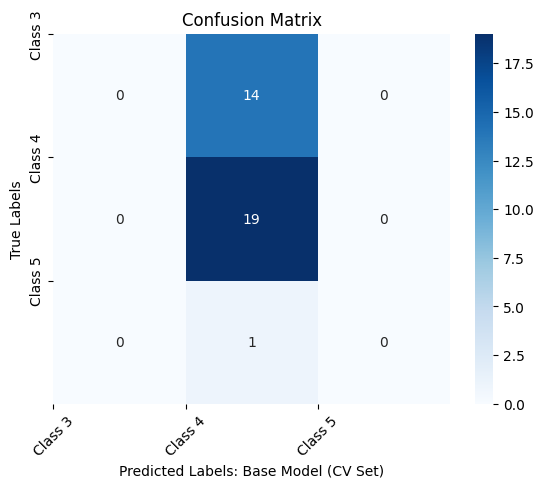

In [ ]:
confusion_matrix_plot_cv(y_test_cv, y_pred_base_cv, 'Base Model (CV Set)')

## **4.2.** Logistic Regression (CV)

In [ ]:
y_probabilities_cv = model_lr.predict_proba(x_test_cv)
y_pred_lr_cv = model_lr.predict(x_test_cv)

accuracy = accuracy_score(y_test_cv, y_pred_lr_cv)
print('Model accuracy:', accuracy)

Model accuracy: 0.6764705882352942


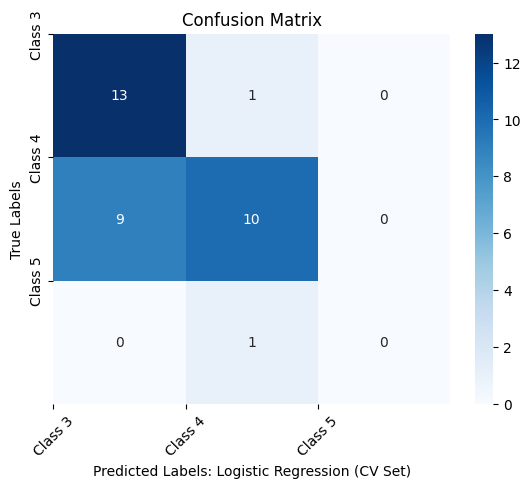

In [ ]:
confusion_matrix_plot_cv(y_test_cv, y_pred_lr_cv, 'Logistic Regression (CV Set)')

## **4.3.** Logistic Regression with PCA (CV)

In [ ]:
cv_pca = cv.copy()
scales_cv = cv_pca[['Extraversion_scale',
             'Conscientiousness_scale',
             'Openness_scale',
             'Agreeableness_scale',
             'Neuroticism_scale']]

non_binary_data_cv = (non_binary_features_cv - non_binary_features_cv.mean())/non_binary_features_cv.std()
data_cv = pd.concat([non_binary_data_cv, binary_features_cv], axis=1)

scales_cols_cv = scales_cv.columns

features_cv = data_cv.drop(scales_cols_cv, axis=1)
features_cv.fillna(999, inplace=True)

pca_cv = PCA()
components_cv = pca_cv.fit_transform(features_cv)

selected_components_cv = components_cv[:, :5] # according to elbow plot above

labels_cv = {
    str(i): f'PC {i+1} ({var:.1f}%)'
    for i, var in enumerate(pca_cv.explained_variance_ratio_ * 100)
}

X_pca_cv = pd.DataFrame(selected_components_cv).iloc[:, :]

In [ ]:
X_pca_cv = pd.DataFrame(selected_components_cv).iloc[:, :]
Y_pca_cv = cv[['Agreeableness_scale']]

agreeableness_upperterc_thr_cv = cv.Agreeableness_scale.quantile([2/3]).values[0]

scaler = MinMaxScaler()
X_pca_cv[X_pca_cv.columns] = scaler.fit_transform(X_pca_cv)

y_test_pca_cv = Y_pca_cv.round(0)

In [ ]:
y_probabilities_pca_cv = model_pca.predict_proba(X_pca_cv)
y_pred_pca_cv = model_pca.predict(X_pca_cv)

accuracy = accuracy_score(y_test_cv, y_pred_pca_cv)
print('Model accuracy:', accuracy)

Model accuracy: 0.47058823529411764


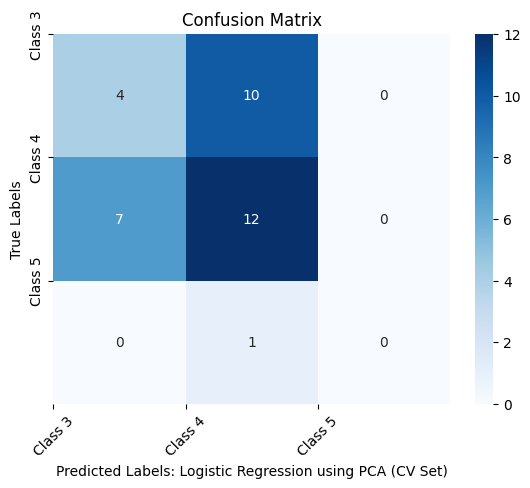

In [ ]:
confusion_matrix_plot_cv(y_test_cv, y_pred_pca_cv, 'Logistic Regression using PCA (CV Set)')

## **4.4.** eXtreme Gradient Boosting (CV)

In [ ]:
encoder = LabelEncoder()
y_test_encoded_cv = y_test_cv.astype(int) - y_test_cv.min().astype(int)

# Order the target variable
ordered_categories = pd.CategoricalDtype(categories=[0, 1, 2, 3], ordered=True)

y_test_encoded_cv = pd.Series(y_test_encoded_cv).astype(ordered_categories).cat.codes

# Make predictions on the test data
y_pred_xgb_cv = best_model_xgb.predict(x_test_cv)

accuracy = accuracy_score(y_test_encoded_cv, y_pred_xgb_cv)
print('Model accuracy:', accuracy)

y_pred_xgb_cv = y_pred_xgb_cv.astype(int)
y_pred_xgb_cv += y_test_cv.min().astype(int)

Model accuracy: 0.29411764705882354


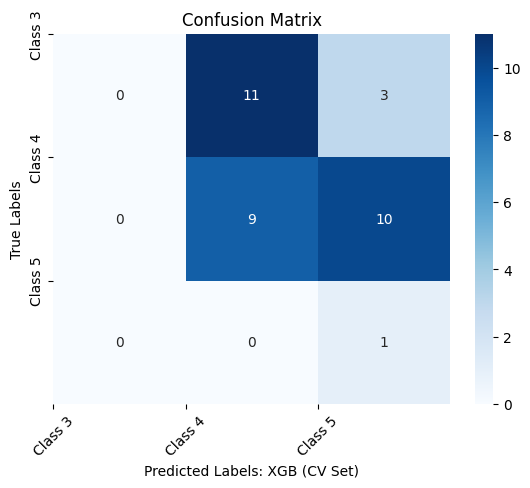

In [ ]:
confusion_matrix_plot_cv(y_test_cv, y_pred_xgb_cv, 'XGB (CV Set)')

## **4.5.** Histogram Gradient Boosting (CV)

In [ ]:
encoder = LabelEncoder()
y_test_encoded_cv = encoder.fit_transform(y_test_cv)

y_pred_hgb_cv = best_model_hgb.predict(x_test_cv)

accuracy = accuracy_score(y_test_encoded_cv, y_pred_hgb_cv)
print('Model accuracy:', accuracy)

y_pred_hgb_cv = encoder.inverse_transform(y_pred_hgb_cv)

Model accuracy: 0.2647058823529412


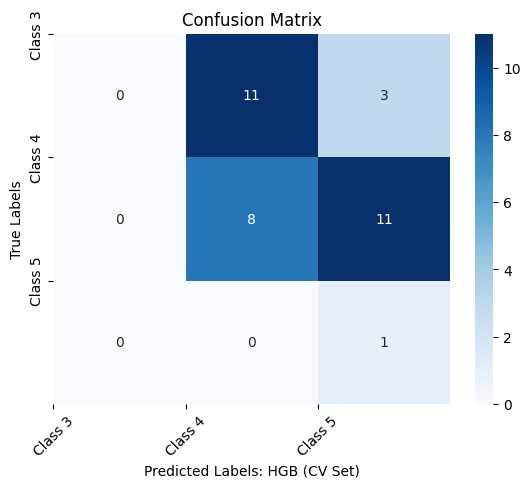

In [ ]:
confusion_matrix_plot_cv(y_test_cv, y_pred_hgb_cv, 'HGB (CV Set)')

## **4.6.** Neural Network (CV)

In [ ]:
scaler = StandardScaler()
x_test_nn_cv = scaler.fit_transform(x_test_cv)

In [ ]:
y_pred_nn_cv = best_model_nn.predict(x_test_nn_cv)
y_pred_nn_cv = y_pred_nn_cv.astype(int)
y_pred_nn_cv += 2

accuracy = accuracy_score(y_test_cv, y_pred_nn_cv)
print('Model accuracy:', accuracy)

2/2 [==============================] - 0s 6ms/step
Model accuracy: 0.7941176470588235


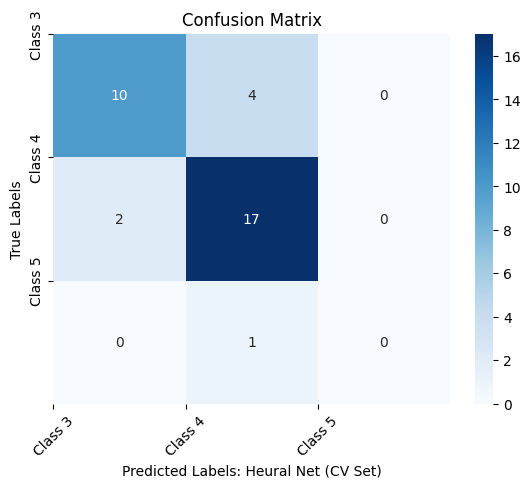

In [ ]:
confusion_matrix_plot_cv(y_test_cv, y_pred_nn_cv, 'Heural Net (CV Set)')